# Assignment - Unsupervised Learning
This assignment is for Big Data in Finance II.

## 0 Setup
Download the lending club data saved on the hub as 
*/Data/lendingclub_cleaned/Loan_data.csv*.

Keep the following list of borrower characteristics:

`[loan_amnt, int_rate, annual_inc, avg_cur_bal, emp_length, fico_range_high, delinq_amnt, revol_util]`

Also keep `loan_status` and convert it into a default indicator (which is one if the loan status is "Fail")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['KERAS_BACKEND']='tensorflow'

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input

np.seterr(all='ignore')
np.random.seed(123)

In [3]:
# load data
df = pd.read_csv('../data/lendingclub_cleaned/Loan_data.csv', low_memory = False, index_col=0)

# keep list of borrower characteristers
clist = ['loan_status', 'loan_amnt', 'int_rate', 'annual_inc', 'avg_cur_bal', 'emp_length', 'fico_range_high', 'delinq_amnt', 'revol_util']
df = df[clist]

# turn loan_status into a default indicator
df['loan_status'] = (df['loan_status'] == 'Fail')

# inspect data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107260 entries, 126413292 to 118607680
Data columns (total 9 columns):
loan_status        107260 non-null bool
loan_amnt          107260 non-null float64
int_rate           107260 non-null float64
annual_inc         107260 non-null float64
avg_cur_bal        107260 non-null float64
emp_length         107260 non-null int64
fico_range_high    107260 non-null float64
delinq_amnt        107260 non-null float64
revol_util         107260 non-null float64
dtypes: bool(1), float64(7), int64(1)
memory usage: 7.5 MB


## 1 Pricipal Components
Compute the first 2 principal components.

Make a biplot and interpret the main sources of variation in the data.

## 2 Visualize Variation
Make a table with the percentage of variance explained by q
principal components. (q = 1 to 8)

Choose suitable number of principal components used in classification.

## 3 Prediction
Reallocate the dataset into 80% traning set, 10% validation set, 10% test set.
Create a synthetic dataset by undersampling non-defaulters(<70%).

Run 8 logistic classifiers that predict default as a function of the first q principal components.

## 4 Tune Parameter
Get implied probabilities of default of all borrowers in validation set.

Use these predictions and actual outcomes to calculate the cross-entropy loss for each q.

Choose q which has the lowest loss on validation set. Evaluate performance of model on test set.

## 5 Alternatives to PCA
Pseudocode for backprop and gradient descent, for a nonlinear q-dimensional representation of consumer characteristics that uses <u>autoencoder</u>. [Goodfellow et al., Ch.14](https://www.deeplearningbook.org/contents/autoencoders.html)

Train this model, get insights relative to PCA.

In [4]:
# set up data for classification
# class label: default
y = df['loan_status'].values.reshape(1,-1)
print(y.shape)

# features: the remaining columns
X = df.drop(columns = 'loan_status').values.T

# standardise inputs
X = (X - np.mean(X,axis=1).reshape(-1,1)) / np.std(X,axis=1).reshape(-1,1)
print(X.shape)

(1, 107260)
(8, 107260)


In [6]:
# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(107260,))

# encoder layers
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(107260, activation='tanh')(decoded)

# construct the autoencoder model
autoencoder = Model(inputs=input_img, outputs=decoded)

# construct the encoder model for plotting
encoder = Model(inputs=input_img, outputs=encoder_output)

# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')


In [8]:
# training
autoencoder.fit(X, X,
                epochs=20,
                batch_size=256,
                shuffle=True)

Epoch 1/20
8/8 [==============================] - 1s 80ms/step - loss: 0.4405
Epoch 2/20
8/8 [==============================] - 1s 74ms/step - loss: 0.4252
Epoch 3/20
8/8 [==============================] - 1s 68ms/step - loss: 0.4222
Epoch 4/20
8/8 [==============================] - 1s 69ms/step - loss: 0.4195
Epoch 5/20
8/8 [==============================] - 1s 75ms/step - loss: 0.4130
Epoch 6/20
8/8 [==============================] - 1s 68ms/step - loss: 0.4088
Epoch 7/20
8/8 [==============================] - 1s 66ms/step - loss: 0.4057
Epoch 8/20
8/8 [==============================] - 1s 65ms/step - loss: 0.4031
Epoch 9/20
8/8 [==============================] - 1s 68ms/step - loss: 0.3996
Epoch 10/20
8/8 [==============================] - 1s 75ms/step - loss: 0.3969
Epoch 11/20
8/8 [==============================] - 1s 65ms/step - loss: 0.3943
Epoch 12/20
8/8 [==============================] - 0s 62ms/step - loss: 0.3928
Epoch 13/20
8/8 [==============================] - 1s 64ms/st

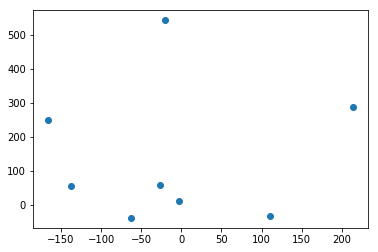

In [9]:
# plotting
encoded_imgs = encoder.predict(X)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1]) # something wrong here
# plt.show()

## 6 K-Means Clustering
Cluster borrowers into K groups using K-means.

In [10]:
# auxiliary functions
def get_means(labels,X,k):
    means = np.zeros((k,X.shape[1]))
    for c in range(k):
        points = X[labels == c]
        means[c,:] = points.mean(axis=0)
    return means
        

# auxiliary function for assigning closest centroids
def get_closest(means,X,k):
    distances = np.zeros((X.shape[0],k))
    for c in range(k):
        diff = X.values - means[c,:]
        distances[:,c] = np.linalg.norm(diff,axis=1)**2
        
    labels = np.argmin(distances,axis=1)
    min_distance = np.min(distances,axis=1)
    
    return labels, min_distance

In [11]:
# set up data for classification
# class label: default
y = df['loan_status']
print(y.shape)

# features: the remaining columns
X = df.drop(columns = 'loan_status')
print(X.shape)

(107260,)
(107260, 8)


In [12]:
k=3
means = X.sample(k,random_state = 123).values
labels, _ = get_closest(means,X,k)
get_closest(means,X,k)

for i in range(100):
    means = get_means(labels,X,k)
    new_labels, min_distance = get_closest(means,X,k)
    if (labels == new_labels).all(): 
        break
    else: 
        labels = new_labels

Text(0,0.5,'Second principal component of returns')

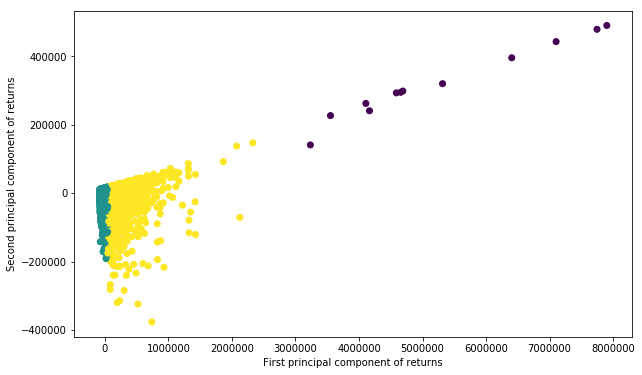

In [13]:
# visualisation
Z = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(10,6))
plt.scatter(Z[:,0],Z[:,1],c=labels)
plt.xlabel('First principal component of returns')
plt.ylabel('Second principal component of returns')

## 7 Tune Paramerter
Design a graphical tool that helps pick good number of K.

Interpret characteristics
of borrowers in each cluster.

Text(0,0.5,'Within-cluster point scatter')

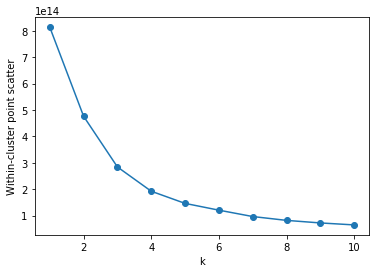

In [14]:
# for speed, use pre-loaded package
distances = []
for k in range(1,11): 
    fitted = KMeans(n_clusters=k,random_state = 234,n_init=10).fit(X)
    distances.append(fitted.inertia_)
plt.plot(range(1,11),distances,'-o')    
plt.xlabel('k')
plt.ylabel('Within-cluster point scatter')

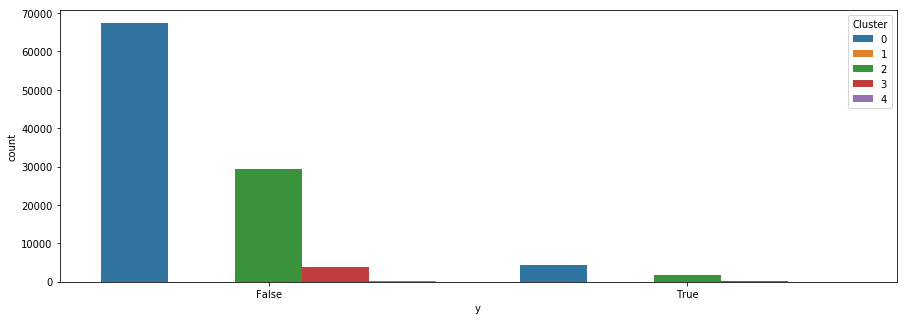

In [15]:
# what are we picking up?
labels = KMeans(n_clusters = 5).fit_predict(X)
plt.figure(figsize=(15,5))
sns.countplot(y.values,hue=labels)
plt.xlabel('y')
plt.legend(title='Cluster')